<a href="https://colab.research.google.com/github/ranton256/classifying_concord/blob/main/supervised_ML_identify_author.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Machine Learning - Identify Author


In [1]:
%pip install -q spacy

In [2]:
# you will need to download the spacy model for english.
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# %pip install -r requirements.txt

In [4]:
import spacy

## The Dataset
Our two datasets are constructed from two related works of 19th century American transcendentalism. These are both public domain.

1. [Essays by Ralph Waldo Emerson by Ralph Waldo Emerson](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F16643)
2. [Walden, and On The Duty Of Civil Disobedience by Henry David Thoreau](https://www.google.com/url?q=https%3A%2F%2Fwww.gutenberg.org%2Febooks%2F205)

These two authors had different writing styles but shared more than their philosophical interests—they were neighbors in Concord, Massachusetts.

These two works are also similar in length when formatted as plain text.

We will use spaCy to segment each work into sections of roughly 3 to 5 sentences each, then build a datafrom of the text including a label of 'emerson' or 'thoreau', then shuffle and split that into train and test sets for training some machine learning models to classify them by predicting which author they are from and compare the results.

We will also preprocess text to remove stopwords,and perform lemmatization.

In [5]:
emerson_txt_url = "https://www.gutenberg.org/ebooks/16643.txt.utf-8"
thoreau_txt_url = "https://www.gutenberg.org/ebooks/205.txt.utf-8"


In [6]:
import requests
from pathlib import Path

In [7]:
def download_file(url):
  local_filename = Path(url.split('/')[-1])
  result = requests.get(url)
  result.raise_for_status()
  with open(local_filename, "wb") as f:
      f.write(result.content)
  return local_filename

In [8]:
emerson_file = download_file(emerson_txt_url)
thoreau_file = download_file(thoreau_txt_url)

In [9]:
!head -n 50 {emerson_file}

﻿The Project Gutenberg eBook of Essays by Ralph Waldo Emerson
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Essays by Ralph Waldo Emerson

Author: Ralph Waldo Emerson

Editor: Edna Henry Lee Turpin

Release date: September 4, 2005 [eBook #16643]
                Most recently updated: April 29, 2022

Language: English

Credits: Curtis A. Weyant, Sankar Viswanathan and the Online Distributed Proofreading Team


*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***




                                ESSAYS

                                  BY

                    

In [10]:
!head -n 50 {thoreau_file}

﻿The Project Gutenberg eBook of Walden, and On The Duty Of Civil Disobedience
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Walden, and On The Duty Of Civil Disobedience

Author: Henry David Thoreau

Release date: January 1, 1995 [eBook #205]
                Most recently updated: September 19, 2024

Language: English

Credits: Judith Boss, and David Widger


*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***
WALDEN




and



ON THE DUTY OF CIVIL DISOBEDIENCE



by Henry David Thoreau


cover


Contents


 WALDEN

 Economy
 Where I Lived, and 

In [11]:
# Let's strip the frontmatter lines off the start of each file.
# remove each line preceding one that contains "START OF THE PROJECT GUTENBERG EBOOK "
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {emerson_file}
!grep -n "START OF THE PROJECT GUTENBERG EBOOK" {thoreau_file}

25:*** START OF THE PROJECT GUTENBERG EBOOK ESSAYS BY RALPH WALDO EMERSON ***
23:*** START OF THE PROJECT GUTENBERG EBOOK WALDEN, AND ON THE DUTY OF CIVIL DISOBEDIENCE ***


In [12]:
def trim_frontmatter(filename):
  with open(filename) as f:
    lines = f.readlines()

  n_trim_lines = 0
  for i, line in enumerate(lines):
    if "START OF THE PROJECT GUTENBERG EBOOK" in line:
      n_trim_lines = i + 1
      break

  trimmed_lines = lines[n_trim_lines:]
  trimmed_content = '\n'.join(trimmed_lines)
  new_filename = f"trimmed_{filename}"
  with open(new_filename, "w") as f:
    f.write(trimmed_content)
  return new_filename

In [13]:
trimmed_emerson_file = trim_frontmatter(emerson_file)
trimmed_thoreau_file = trim_frontmatter(thoreau_file)

In [14]:
!head {trimmed_emerson_file}
!head {trimmed_thoreau_file}









                                ESSAYS

WALDEN











In [15]:
from collections import deque
from random import randint
import itertools


In [16]:
nlp = spacy.load("en_core_web_sm")
# if you have an error here, make sure you ran the "!python -m spacy download en_core_web_sm" command in the earlier cell.

In [17]:
def segment_doc(filename):
  with open(filename) as f:
    text = f.read()
  doc = nlp(text)
  assert doc.has_annotation("SENT_START")

  sent_dq = deque()
  #it = doc.sents.__iter__()
  n = randint(3, 5)

  for sent in doc.sents:
    sent_dq.append(sent)
    if len(sent_dq) > n:
      sent_dq.popleft()
      snippet = " ".join(sent.text for sent in sent_dq)
      yield snippet
      n = randint(3, 5)
      sent_dq.clear()

In [18]:
import pandas as pd

In [19]:
def dataframe_from_file(file_path):
  segments = segment_doc(file_path)

  df = pd.DataFrame(segments, columns=["text"])
  return df


In [20]:
emerson_df = dataframe_from_file(trimmed_emerson_file)
emerson_df.to_csv("emerson.csv")
emerson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1076 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [21]:
emerson_df.head()

,text
0,The editors of the several volumes will be\n\n...
1,He was descended\n\nfrom a long line of New En...
2,After graduating from college he taught school...
3,His talent seems to have been in\n\ngiving new...
4,It is\n\ncharacteristic of his deep humanity a...


In [22]:

thoreau_df = dataframe_from_file(trimmed_thoreau_file)
thoreau_df.to_csv("thoreau.csv")
thoreau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    843 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [23]:
thoreau_df.head()

,text
0,I lived there two\n\nyears and two months. At ...
1,I will therefore ask those of my readers who f...
2,"Moreover, I, on my side, require of every writ..."
3,What\n\nI have heard of Brahmins sitting expos...
4,"Why should they eat their sixty acres, when ma..."


In [24]:
# combine and shuffle the datasets, using a consistent random seed.
from sklearn.utils import shuffle

d1 = emerson_df.copy()
d1["label"] = "emerson"

d2 = thoreau_df.copy()
d2["label"] = "thoreau"

combined_df = pd.concat([d1, d2])
combined_df = shuffle(combined_df, random_state=7919)
combined_df.to_csv("combined.csv")
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 146 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1919 non-null   object
 1   label   1919 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


,text,label
146,The squirrel tribe tried the\n\nsame and succe...,thoreau
638,"If you meet a sectary or a hostile partisan, n...",emerson
58,Of\n\ntwo patterns which differ only by a few ...,thoreau
409,"In a good lord, there\n\nmust first be a good ...",emerson
30,"Most of the luxuries, and many of the so calle...",thoreau


## Now we have our dataset in combined.csv


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# you can start here if csv files were already created.
from sklearn.feature_extraction.text import TfidfVectorizer

<ipython-input-27-3711010374>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=combined_df["label"], palette="rocket")


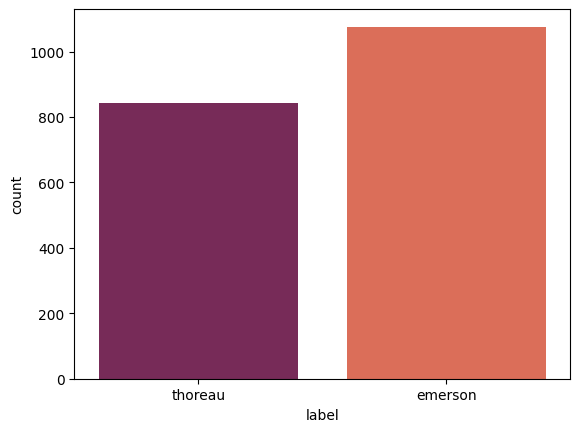

In [27]:
sns.countplot(x=combined_df["label"], palette="rocket")
plt.show()


In [28]:
%pip install -q wordcloud

In [29]:
from spacy.lang.en import STOP_WORDS
my_stopwords = STOP_WORDS

', '.join(my_stopwords)

"just, only, ’s, was, the, is, someone, whereafter, around, nobody, ‘ll, should, nevertheless, further, up, i, themselves, be, those, full, side, part, your, put, elsewhere, many, using, myself, him, also, on, whom, regarding, more, have, eleven, beforehand, itself, give, whoever, anywhere, may, whereas, enough, whatever, amount, formerly, while, ‘d, due, first, another, besides, afterwards, his, unless, through, neither, made, ’d, yourself, perhaps, during, yourselves, herein, become, anyone, their, within, ’ve, forty, take, this, re, 've, done, about, noone, over, please, meanwhile, some, has, bottom, in, therein, might, both, for, since, four, hereafter, against, latterly, whereby, twenty, again, behind, my, from, sometime, 're, he, each, former, 's, across, does, whose, among, yet, everywhere, herself, and, moreover, well, except, me, onto, did, whole, already, still, ’ll, really, sixty, than, last, it, there, even, ‘re, serious, under, too, ‘ve, every, ourselves, above, ’re, any, 

In [30]:
# Show wordcloud from each dataset.
from wordcloud import WordCloud


def plot_word_cloud(text_sections, title):
  cloud = WordCloud(background_color='black', stopwords=my_stopwords).generate(str(text_sections))
  fig = plt.figure(figsize=(12,8), facecolor='white')
  plt.imshow(cloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(title, fontsize=48)
  plt.tight_layout(pad=0)
  plt.show()




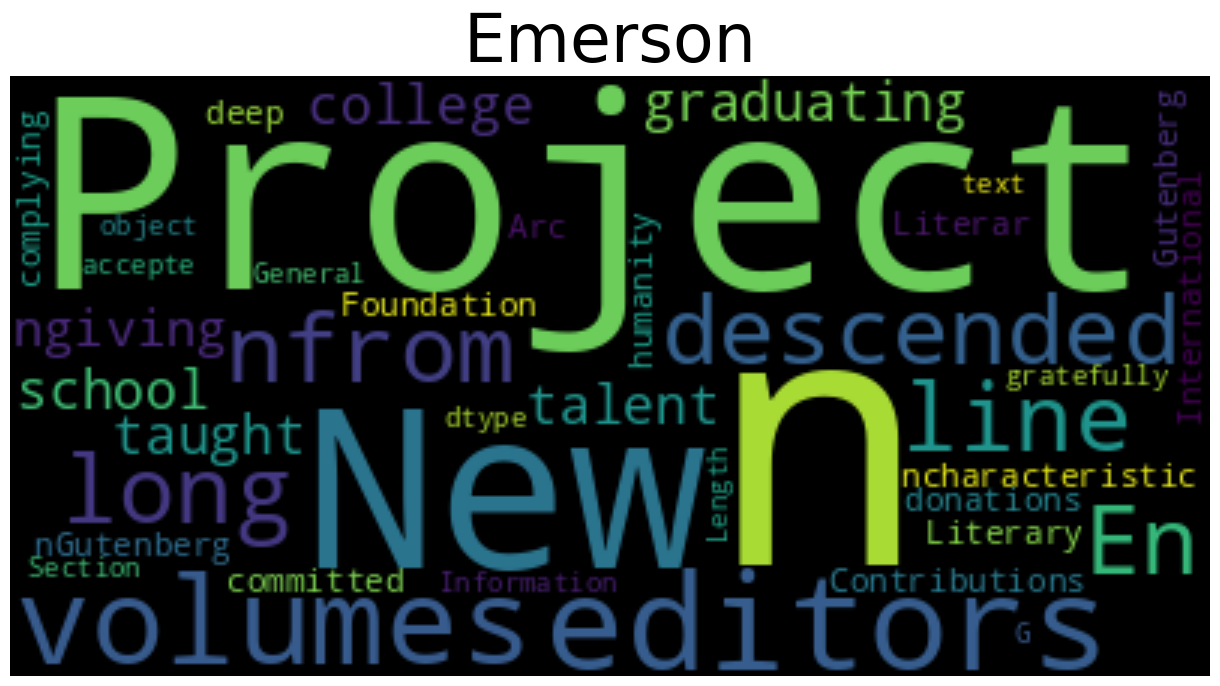

In [31]:
plot_word_cloud(emerson_df["text"], "Emerson")

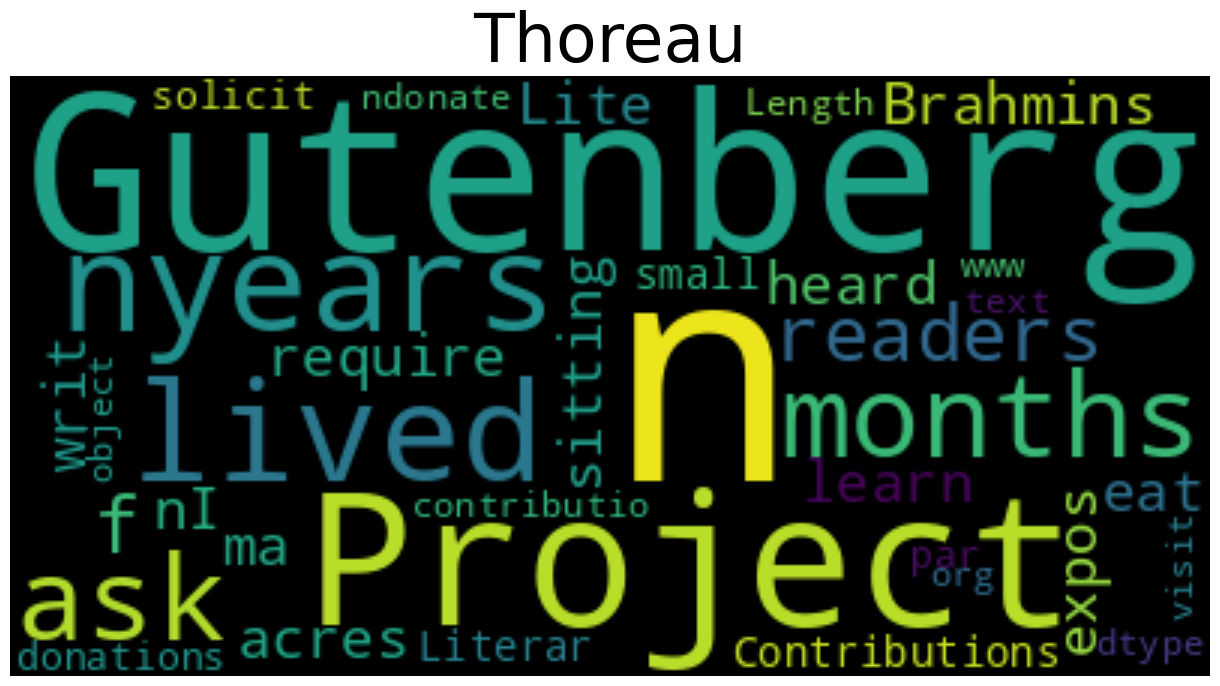

In [32]:
plot_word_cloud(thoreau_df["text"], "Thoreau")

## Traditional (Non-Transformer) Models

In [33]:
# Preprocess text to remove stopwords, and perform lemmatization.

final_text = []
for index,entry in enumerate(combined_df['text']):
  doc = nlp(entry.lower())
  Final_words = []
  for word in doc:
    if not word.is_stop and not word.is_punct:
      Final_words.append(word.lemma_)
  final_text.append(' '.join(Final_words))



In [34]:
combined_df['final_text'] = final_text
combined_df.head()

,text,label,final_text
146,The squirrel tribe tried the\n\nsame and succe...,thoreau,squirrel tribe try \n\n succeed human race int...
638,"If you meet a sectary or a hostile partisan, n...",emerson,meet sectary hostile partisan \n\n recognize d...
58,Of\n\ntwo patterns which differ only by a few ...,thoreau,\n\n pattern differ thread \n\n particular col...
409,"In a good lord, there\n\nmust first be a good ...",emerson,good lord \n\n good animal extent yield \n\n i...
30,"Most of the luxuries, and many of the so calle...",thoreau,luxury call comfort life \n\n indispensable po...


In [35]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df["final_text"])
y = combined_df["label"]


In [36]:
# split our data into train and test sets.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4909)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (1535, 11915)
y_train: (1535,)
x_test: (384, 11915)
y_test: (384,)


In [37]:
from sklearn.linear_model import LogisticRegression


In [38]:
# -2 for n_jobs is all but one CPU available.
lr_model = LogisticRegression(solver='saga', random_state=8102, n_jobs=-2)

lr_model.fit(x_train, y_train)

LogisticRegression(n_jobs=-2, random_state=8102, solver='saga')

In [39]:
y_pred = lr_model.predict(x_test)

In [40]:
from sklearn.metrics import f1_score

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Markdown, display

def show_metrics(y_test, y_pred, model_name):
  display(Markdown(f"# {model_name}"))

  print(classification_report(y_test,y_pred))
  print("Test accuracy:", accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)

  labels = ["emerson", "thoreau"]
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# Logistic Regression

              precision    recall  f1-score   support

     emerson       0.86      0.94      0.90       220
     thoreau       0.91      0.80      0.85       164

    accuracy                           0.88       384
   macro avg       0.89      0.87      0.88       384
weighted avg       0.88      0.88      0.88       384

Test accuracy: 0.8802083333333334


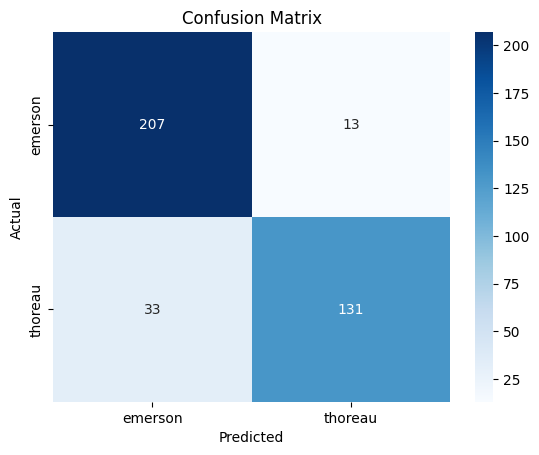

In [42]:
show_metrics(y_test, y_pred, "Logistic Regression")

In [43]:
# Let's compare that to random forests.


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)


RandomForestClassifier()

In [44]:
y_pred_rf = rf.predict(x_test)

# Random Forest

              precision    recall  f1-score   support

     emerson       0.82      0.89      0.85       220
     thoreau       0.83      0.73      0.78       164

    accuracy                           0.82       384
   macro avg       0.82      0.81      0.81       384
weighted avg       0.82      0.82      0.82       384

Test accuracy: 0.8203125


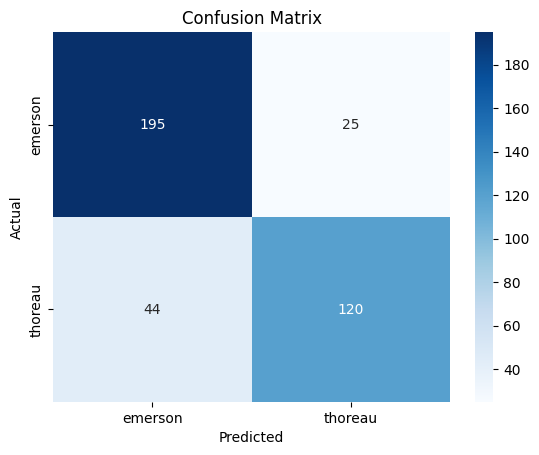

In [45]:
show_metrics(y_test, y_pred_rf, "Random Forest")

In [46]:
from sklearn import svm

In [47]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train,y_train)
clf

SVC()

In [48]:
y_pred_svm = clf.predict(x_test)

# SVM

              precision    recall  f1-score   support

     emerson       0.88      0.93      0.90       220
     thoreau       0.90      0.82      0.86       164

    accuracy                           0.89       384
   macro avg       0.89      0.88      0.88       384
weighted avg       0.89      0.89      0.88       384

Test accuracy: 0.8854166666666666


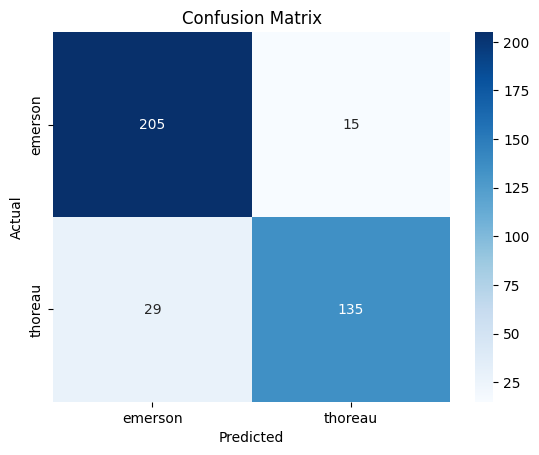

In [49]:
show_metrics(y_test, y_pred_svm, "SVM")

In [50]:
# TODO: if not colab
#%pip install -q transformers

In [51]:
# TODO: if not colab
#%pip install -q torch

In [52]:
import torch

In [53]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [54]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_token_type_ids = False, padding="max_length", truncation=True)

model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


In [55]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(combined_df["text"], combined_df["label"], test_size=0.2, random_state=4909)
print(f"x_train_s: {x_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"x_test_s: {x_test_s.shape}")
print(f"y_test_s: {y_test_s.shape}")


x_train_s: (1535,)
y_train_s: (1535,)
x_test_s: (384,)
y_test_s: (384,)


In [56]:
x_train_tok = tokenizer(x_train_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_train_tok = y_train_s.tolist()

x_test_tok = tokenizer(x_test_s.tolist(), padding=True, truncation=True, return_tensors="pt")
y_test_tok = y_test_s.tolist()


In [57]:
x_train_tok[0:2]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [58]:

print(x_train_tok.keys())


#move onto device (GPU)
x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}

dict_keys(['input_ids', 'attention_mask'])


<ipython-input-58-3140837852>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tok = {k:torch.tensor(v).to(device) for k,v in x_train_tok.items()}
<ipython-input-58-3140837852>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tok = {k:torch.tensor(v).to(device) for k,v in x_test_tok.items()}


In [59]:
with torch.no_grad():
  hidden_train = model(**x_train_tok)
  hidden_test = model(**x_test_tok)

# Get the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [60]:
x_train_db = cls_train.to("cpu")
# y_train_tok

x_test_db = cls_test.to("cpu")
# y_test_tok


In [61]:
lr_model2 = LogisticRegression(C=1, solver='saga', random_state=8102, n_jobs=-2, max_iter=10_000)

lr_model2.fit(x_train_db,y_train_tok)

# This does not converge, with the settings used for TF-DF
# ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# So we adjusting max_iter and experimented with C (regulation strength).

y_pred = lr_model2.predict(x_test_db)


# Logistic Regression on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.92      0.95      0.93       220
     thoreau       0.92      0.88      0.90       164

    accuracy                           0.92       384
   macro avg       0.92      0.91      0.92       384
weighted avg       0.92      0.92      0.92       384

Test accuracy: 0.9192708333333334


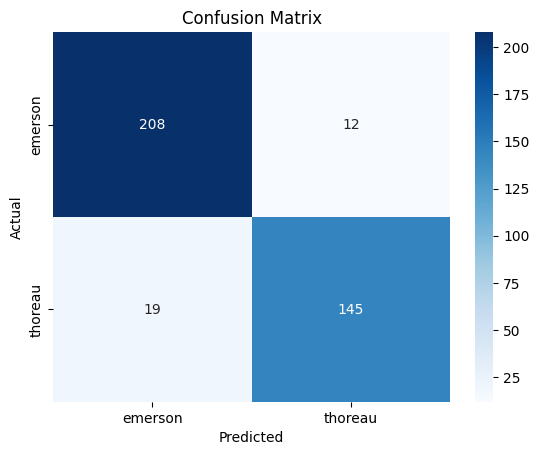

In [62]:
show_metrics(y_test_tok, y_pred, "Logistic Regression on DistilBERT hidden states")

In [63]:
rf = RandomForestClassifier()
rf.fit(x_train_db,y_train_tok)

rf.score(x_test_db,y_test_tok)

y_pred_rf = rf.predict(x_test_db)

# Random Forest on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.85      0.93      0.89       220
     thoreau       0.90      0.79      0.84       164

    accuracy                           0.87       384
   macro avg       0.88      0.86      0.86       384
weighted avg       0.87      0.87      0.87       384

Test accuracy: 0.8697916666666666


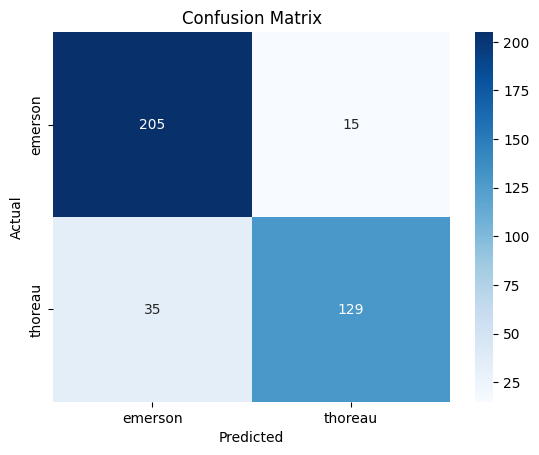

In [64]:
show_metrics(y_test_tok, y_pred_rf, "Random Forest on DistilBERT hidden states")

In [65]:
from sklearn import svm

In [66]:
# create the SVM classifier
clf = svm.SVC(kernel='rbf')

clf.fit(x_train_db,y_train_tok)

y_pred_svm = clf.predict(x_test_db)

# SVM on DistilBERT hidden states

              precision    recall  f1-score   support

     emerson       0.89      0.95      0.92       220
     thoreau       0.93      0.85      0.89       164

    accuracy                           0.91       384
   macro avg       0.91      0.90      0.90       384
weighted avg       0.91      0.91      0.91       384

Test accuracy: 0.90625


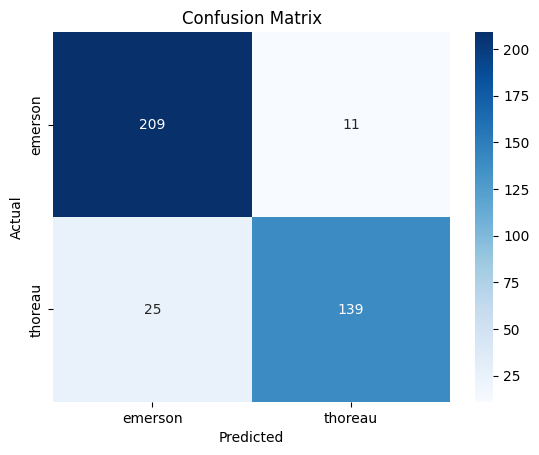

In [67]:
show_metrics(y_test_tok, y_pred_svm, "SVM on DistilBERT hidden states")

In [68]:

from transformers import DistilBertForSequenceClassification

# Define the model with random weights, suitable for binary classification (2 classes)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
# we already have the appropriate tokenizer from before.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# create our optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [70]:
!pip install -q datasets

In [71]:
from sklearn import preprocessing

# Create a copy of our dataframe
trans_df = combined_df.copy()

# drop the preprocessed text column which we aren't using.
trans_df.drop("final_text", axis=1, inplace=True)

# transform our labels into numeric values.
le = preprocessing.LabelEncoder()
my_labels = trans_df["label"].tolist()
le.fit(my_labels)

my_cat_labels = le.classes_
trans_df["label"] = le.transform(trans_df["label"])

print(f"{my_cat_labels=}")

trans_df.info()
trans_df.describe()
trans_df.head()


my_cat_labels=array(['emerson', 'thoreau'], dtype='<U7')
<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 146 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1919 non-null   object
 1   label   1919 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.0+ KB


,text,label
146,The squirrel tribe tried the\n\nsame and succe...,1
638,"If you meet a sectary or a hostile partisan, n...",0
58,Of\n\ntwo patterns which differ only by a few ...,1
409,"In a good lord, there\n\nmust first be a good ...",0
30,"Most of the luxuries, and many of the so calle...",1


In [72]:
from datasets import Dataset
from transformers import AutoTokenizer

# for simplicity, we are just splitting the dataset again.
train_df, test_df = train_test_split(trans_df, test_size=0.2, random_state=4909)



train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

In [73]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # this parameter was apparently removed recently.
    # evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none" # prevent prompt to login to W & B
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-73-2241263378>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
192,0.407800
384,0.400700
576,0.260500
768,0.133500
960,0.095900


TrainOutput(global_step=960, training_loss=0.2596654713153839, metrics={'train_runtime': 46.419, 'train_samples_per_second': 165.342, 'train_steps_per_second': 20.681, 'total_flos': 437458577988936.0, 'train_loss': 0.2596654713153839, 'epoch': 5.0})

In [74]:
# Save the model.
trainer.save_model('model')

In [75]:
# This is how you can load the model.

# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("./model")

In [76]:
def predictor(text):
  #inputs = tokenizer(text, return_tensors="pt")
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}

  with torch.no_grad():
      logits = model(**inputs).logits
  predictions = torch.argmax(logits, dim=-1)
  return predictions


In [77]:
x_test_trans = test_dataset["text"]
y_test_trans = test_dataset["label"]

# sanity test a few inference inputs.
for txt, lbl in zip(x_test_trans[:5], y_test_trans[:5]):
  pred = predictor( txt)
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")

emerson: pred=emerson, txt="That popular\n\nfable of the sot who was picked up dead drunk in the street, carried\n\nto the duke's house, washed and dressed and laid in the duke's bed,\n\nand, on his waking, treated with all obsequious ceremony like the\n\nduke, and assured that he had been insane,[206] owes its popularity to\n\nthe fact that it symbolizes so well the state of man, who is in the\n\nworld a sort of sot, but now and then wakes up, exercises his reason,\n\nand finds himself a true prince.\n\n\n\n Our reading is mendicant and sycophantic. In history, our imagination\n\nplays us false."
emerson: pred=emerson, txt='In the fourth century before Christ he made himself master of\n\nthe known world.]\n\n\n\n [Footnote 393: Pericles. See note on _Heroism_, 352.]\n\n\n\n [Footnote 394: Diogenes. (See note 267.)]\n\n\n\n'
thoreau: pred=thoreau, txt='Even the little variety which I used was a yielding\n\nto the demands of appetite, and not of health. Yet men have come to\n\nsuch a pa

<ipython-input-76-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


In [78]:
y_pred_trans = [predictor(txt) for txt in x_test_trans]

for txt, lbl, pred in zip(x_test_trans[:5], y_test_trans[:5], y_pred_trans[:5]):
  print(f"{my_cat_labels[lbl]}: pred={my_cat_labels[pred]}, {txt=}")


<ipython-input-76-312163856>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k:torch.tensor(v).to(device) for k,v in inputs.items()}


emerson: pred=emerson, txt="That popular\n\nfable of the sot who was picked up dead drunk in the street, carried\n\nto the duke's house, washed and dressed and laid in the duke's bed,\n\nand, on his waking, treated with all obsequious ceremony like the\n\nduke, and assured that he had been insane,[206] owes its popularity to\n\nthe fact that it symbolizes so well the state of man, who is in the\n\nworld a sort of sot, but now and then wakes up, exercises his reason,\n\nand finds himself a true prince.\n\n\n\n Our reading is mendicant and sycophantic. In history, our imagination\n\nplays us false."
emerson: pred=emerson, txt='In the fourth century before Christ he made himself master of\n\nthe known world.]\n\n\n\n [Footnote 393: Pericles. See note on _Heroism_, 352.]\n\n\n\n [Footnote 394: Diogenes. (See note 267.)]\n\n\n\n'
thoreau: pred=thoreau, txt='Even the little variety which I used was a yielding\n\nto the demands of appetite, and not of health. Yet men have come to\n\nsuch a pa

In [79]:
y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]

<ipython-input-79-2635634608>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_trans = [torch.tensor(v).cpu() for v in y_pred_trans]


In [80]:
y_test_trans = [torch.tensor(v).cpu() for v in y_test_trans]

# Fine-tuned DistilBERT

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       220
           1       0.92      0.92      0.92       164

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384

Test accuracy: 0.9322916666666666


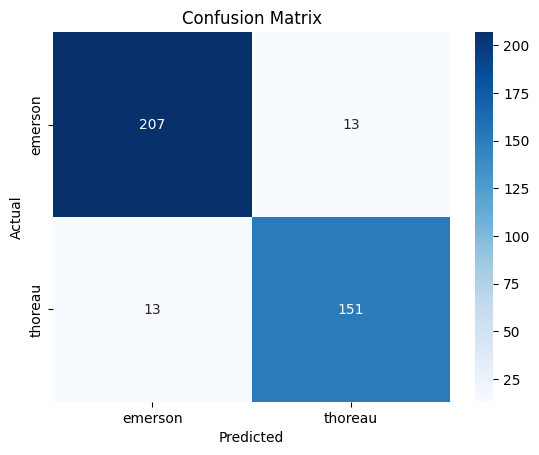

In [81]:
show_metrics(y_pred_trans, y_test_trans, "Fine-tuned DistilBERT")

## Let's check out the test samples that are misclassified.

In [82]:
def scalar_from_tensor(t):
  if t.dim() == 0:
    return t.item()
  elif t.dim() == 1:
    return t[0].item()
  else:
    raise ValueError(f"Unexpected tensor dimension: {t.dim()}")


In [83]:

y_test_trans = [scalar_from_tensor(t) for t in y_test_trans]
y_pred_trans = [scalar_from_tensor(t) for t in y_pred_trans]

print(f"y_test_trans: {y_test_trans[:5]}")
print(f"y_pred_trans: {y_pred_trans[:5]}")


y_test_trans: [0, 0, 1, 0, 0]
y_pred_trans: [0, 0, 1, 0, 0]


In [84]:
print("my_cat_labels")

rows = []
for i, (txt, lbl, pred) in enumerate(zip(x_test_trans, y_test_trans, y_pred_trans)):
  if lbl != pred:
    print(f"{lbl=},{pred=}")
    row =(my_cat_labels[lbl], my_cat_labels[pred], txt)
    print(f"{row=}")
    rows.append(row)

n_miss = len(rows)
print(f"Count of misclassified = {n_miss}")
misclassified_df = pd.DataFrame(rows, columns=["actual", "predicted", "text"])
misclassified_df.head(n_miss)


my_cat_labels
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'When we consider what, to use the words of the catechism, is the chief\n\nend of man, and what are the true necessaries and means of life, it\n\nappears as if men had deliberately chosen the common mode of living\n\nbecause they preferred it to any other. Yet they honestly think there\n\nis no choice left. But alert and healthy natures remember that the sun\n\nrose clear.')
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'Additional terms\n\nwill be linked to the Project Gutenberg™ License for all works\n\nposted with the permission of the copyright holder found at the\n\nbeginning of this work.\n\n\n\n 1.E.4. Do not unlink or detach or remove the full Project Gutenberg™\n\nLicense terms from this work, or any files containing a part of this\n\nwork or any other work associated with Project Gutenberg™.\n\n\n\n')
lbl=1,pred=0
row=(np.str_('thoreau'), np.str_('emerson'), 'Their truth is instantly _translat

,actual,predicted,text
0,thoreau,emerson,"When we consider what, to use the words of the..."
1,thoreau,emerson,Additional terms\n\nwill be linked to the Proj...
2,thoreau,emerson,Their truth is instantly _translated_; its lit...
3,thoreau,emerson,The intellect\n\nis a cleaver; it discerns and...
4,thoreau,emerson,If you\n\n are not located in the United St...
5,thoreau,emerson,All\n\nintelligence seems reflected in them. T...
6,thoreau,emerson,In his view the\n\nearth is all equally cultiv...
7,emerson,thoreau,And the\n\nbeauty of nature must always seem u...
8,thoreau,emerson,General Terms of Use and Redistributing Projec...
9,emerson,thoreau,The\n\nknapsack of custom falls off his back w...
